Generate a movie for a single trajectory.

In [14]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

In [15]:
all_data_fp = "../../analysis_data/all_data.csv"

df = pd.read_csv(all_data_fp)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,min_epsilon,min_beta,sender_delta,receiver_delta
0,1.526090e+00,1.270097,0.641931,2.278652e+00,[0.0054146544510602634],0.012748,1.095495,0.0,simulation,NaN,...,1.0,0,replicator_diffusion,0.0,-8.0,6.0,NaN,NaN,NaN,NaN
1,0.000000e+00,0.000000,1.912028,1.640000e+01,NaN,NaN,NaN,1.0,trajectory,0.0,...,1.0,0,replicator_diffusion,0.0,-8.0,6.0,NaN,NaN,NaN,NaN
2,0.000000e+00,0.000000,1.912028,1.633083e+01,NaN,NaN,NaN,1.0,trajectory,1.0,...,1.0,0,replicator_diffusion,0.0,-8.0,6.0,NaN,NaN,NaN,NaN
3,0.000000e+00,0.000000,1.912028,1.627849e+01,NaN,NaN,NaN,1.0,trajectory,2.0,...,1.0,0,replicator_diffusion,0.0,-8.0,6.0,NaN,NaN,NaN,NaN
4,8.881784e-16,0.000000,1.912028,1.623663e+01,NaN,NaN,NaN,1.0,trajectory,3.0,...,1.0,0,replicator_diffusion,0.0,-8.0,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473265,6.643856e+00,NaN,NaN,4.877432e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473266,6.643856e+00,NaN,NaN,3.804261e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473267,6.643856e+00,NaN,NaN,2.967218e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473268,6.643856e+00,NaN,NaN,2.314348e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma=0",
    "game.discriminative_need_gamma=-3", # important filter for movie
    "simulation.dynamics.population_init_gamma=-3",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.max_its=200", # important to specify maxits
    "seed=0",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


In [17]:
game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")


In [18]:
def get_df_subsetted_by_bound(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the config."""

    # Configs specific only to the game (not dynamics)
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    dynamics = df["dynamics"].isin([
        config.simulation.dynamics.name, # target dynamics
        np.nan, # for NaNs to allow the ib curve itself
    ])

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & dynamics]

    return df_subsetted

In [19]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, config)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,min_epsilon,min_beta,sender_delta,receiver_delta
11918,4.472423,4.231457,0.880214,3.364020e+00,[0.0012551767898488775],0.002515,0.974474,0.0,simulation,NaN,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11919,5.700037,4.230767,0.880905,1.916312e+03,NaN,NaN,NaN,1.0,trajectory,0.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11920,4.063767,3.801191,1.310480,2.590330e+02,NaN,NaN,NaN,1.0,trajectory,1.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11921,3.954168,3.763000,1.348672,1.093071e+02,NaN,NaN,NaN,1.0,trajectory,2.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11922,3.945152,3.772649,1.339022,3.420761e+01,NaN,NaN,NaN,1.0,trajectory,3.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473265,6.643856,NaN,NaN,4.877432e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473266,6.643856,NaN,NaN,3.804261e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473267,6.643856,NaN,NaN,2.967218e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473268,6.643856,NaN,NaN,2.314348e-14,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# FURTHER restrict SIMULATION points to the settings we specified in config

df_emergent = df[(df["point_type"].isin(["simulation", "trajectory"]))]
#  & (df["discriminative_need_gamma"] == config.game.discriminative_need_gamma) & (df["population_init_gamma"] == config.simulation.dynamics.population_init_gamma)

#  & (df["seed"] == config.seed)

df_emergent

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,min_epsilon,min_beta,sender_delta,receiver_delta
11918,4.472423,4.231457,0.880214,3.364020,[0.0012551767898488775],0.002515,0.974474,0.0,simulation,NaN,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11919,5.700037,4.230767,0.880905,1916.311862,NaN,NaN,NaN,1.0,trajectory,0.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11920,4.063767,3.801191,1.310480,259.032955,NaN,NaN,NaN,1.0,trajectory,1.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11921,3.954168,3.763000,1.348672,109.307059,NaN,NaN,NaN,1.0,trajectory,2.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
11922,3.945152,3.772649,1.339022,34.207610,NaN,NaN,NaN,1.0,trajectory,3.0,...,0.0,0,imprecise_conditional_imitation,0.0,2.0,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465088,3.220739,3.175522,1.936149,14.737861,NaN,NaN,NaN,1.0,trajectory,995.0,...,-2.0,0,imprecise_conditional_imitation,0.0,-2.0,3.0,NaN,NaN,NaN,NaN
465089,3.220740,3.175522,1.936149,14.737858,NaN,NaN,NaN,1.0,trajectory,996.0,...,-2.0,0,imprecise_conditional_imitation,0.0,-2.0,3.0,NaN,NaN,NaN,NaN
465090,3.220740,3.175523,1.936149,14.737855,NaN,NaN,NaN,1.0,trajectory,997.0,...,-2.0,0,imprecise_conditional_imitation,0.0,-2.0,3.0,NaN,NaN,NaN,NaN
465091,3.220740,3.175523,1.936148,14.737853,NaN,NaN,NaN,1.0,trajectory,998.0,...,-2.0,0,imprecise_conditional_imitation,0.0,-2.0,3.0,NaN,NaN,NaN,NaN


In [21]:
df_final_points = df_emergent[df_emergent["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

In [22]:
# convert seed to categorical
df_final_points.seed = df_final_points.seed.astype(str)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 897 rows containing missing values.


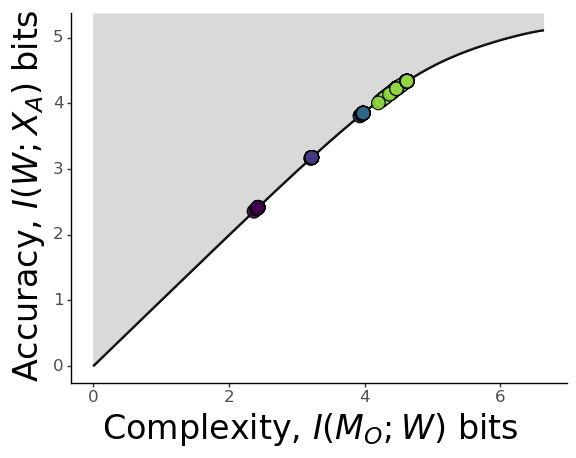

In [23]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # shape="seed",
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        # fill = "#440154",
        alpha=0.9,
        size=5,
    )        
        + pn.xlim([0,np.log2(100)])
        + pn.xlab("Complexity, $I(M_O;W)$ bits")
        + pn.ylab("Accuracy, $I(W;X_A)$ bits")
        # + pn.ylab("Informativeness, $I(W;U)$ bits")


        + pn.theme_classic()
        + pn.theme(
            # Axis font
            axis_title=pn.element_text(size=24),
            axis_text=pn.element_text(size=12),
            # Legend position
            # legend_position=(0.75, 0.4),
            legend_position='none',
        )    
)
print(plot)

In [24]:
def bound_plot_time_step(df_t: pd.DataFrame, t: str) -> pn.ggplot:
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=np.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=df_t,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
            # fill = "#440154",
            alpha=0.9,
            size=5,
        )        
        + pn.xlim([0,np.log2(100)])
        + pn.xlab("Complexity, $I(M_O;W)$ bits")
        + pn.ylab("Accuracy, $I(W;X_A)$ bits")
        # + pn.ylab("Informativeness, $I(W;U)$ bits")
        + pn.ggtitle(f"t={t+1}")

        + pn.theme_classic()
        + pn.theme(
            # Axis font
            axis_title=pn.element_text(size=24),
            axis_text=pn.element_text(size=12),
            # Legend position
            # legend_position=(0.75, 0.4),
            legend_position='none',
        )    

    )
    

In [25]:
df_traj = df_emergent[df_emergent["point_type"] == "trajectory"]
df_traj["t"] = df_traj["round"]

for time_step in range(200):
    plot = bound_plot_time_step(df_traj[df_traj["t"] == time_step], time_step)
    plot.save(f"bound_movie/plots/t_{int(time_step)}.png", width=8, height=8, dpi=300,)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 8 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bound_movie/plots/t_0.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 897 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 8 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: bound_movie/plots/t_1.png
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 897 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggpl

In [26]:
# Run ffmpeg command
import os
os.system("ffmpeg -f image2 -framerate 10 -i  ./bound_movie/plots/t_%d.png -vcodec mpeg4 -y ./bound_movie/movie/trajectory_on_bound.mp4")

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

0